In [2]:
import MGTomo.model as mgmodel
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import mylog, mydiv
import MGTomo.functions as fcts
from MGTomo.optimize import armijo_linesearch, orthant_bounds_optimized

from MGTomo.gridop import RBox as R, PBox as P

from MGTomo import gridop

import time
import numpy as np
import torch
from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 
from skimage import data
from skimage.transform import resize

In [3]:
N = 1023
max_levels = 5
maxIter = [1,2,4,40,40,40]

# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 200, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}
P_nonzero = []


for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    model_coarse = mgmodel.astra_model(coarse_dim, {'mode' : 'line', 'num_angles' : min(int(coarse_dim*np.pi/4),100), 'level_decrease' : 1})
    A.append(mgproj.TomoTorch(model_coarse.proj_factory(coarse_dim)))
    x_resized = resize(x_orig, (coarse_dim, coarse_dim), anti_aliasing=False)
    xT_resized = torch.tensor(x_resized, requires_grad = True)
    b.append(A[-1](xT_resized))
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [10]:
A[0].shape

(204600, 1046529)

In [4]:
# model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 100, 'level_decrease' : 1})
# fine_dim = model.dim
# A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
# b = [A[0](x_torch)]
# level = {int(np.sqrt(A[0].shape[1])): 0}
# P_nonzero = []


# for i in range(1,max_levels+1):
#     coarse_dim = model.reduce_dim(fine_dim)
#     A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
#     b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
#     P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
#     level.update({int(np.sqrt(A[i].shape[1])): i})
#     fine_dim=coarse_dim

In [6]:
for i in range(max_levels+1):
    assert b[i].shape[0]*b[i].shape[1] == A[i].shape[0], 'dimension mismatch'
    print(f'level {i}:', b[i].shape[0], np.sqrt(A[i].shape[1]))

level 0: 200 1023.0
level 1: 100 511.0
level 2: 100 255.0
level 3: 99 127.0
level 4: 49 63.0
level 5: 24 31.0


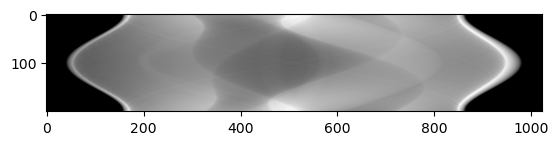

In [8]:
plt.imshow(b[0].detach(), cmap='gray')

In [7]:
def kl_distance_rev(x: torch.tensor, b: torch.tensor, A):
    ax = A(x)
    ax.requires_grad_(True)
    ba = mydiv(b,ax)
    
    erg = b * mylog(ba) - b + ax
    #fx = torch.sum(erg[b > 0.])
    fx = torch.sum( erg[ax > 0.]) + 0.5*torch.sum(b[ax == 0.]**2)
    assert fx >= 0, fx
    #assert fx >= 0, 'kl distance error: output is negative.'
    return fx.requires_grad_(True)

In [8]:
lbd = 0.5
rho = 0.01
fh = lambda x: kl_distance_rev(x, b[0], A[0]) 
#+ lbd * fcts.tv_huber(fcts.nabla(x), rho)
tau = [0.5 * torch.reciprocal(matrix_norm(bi, ord = 1)) for bi in b]
P_inf = 1

In [9]:
tau

[tensor(1.4144e-05, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(5.6696e-05, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0001, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0002, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0009, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0040, dtype=torch.float64, grad_fn=<MulBackward0>)]

In [10]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

norm_fval_SL = []
norm_fval_SL.append(torch.tensor(1.))

fhw = fh(w0)
w0.retain_grad()
fhw.backward(retain_graph=True)
Gw0 = matrix_norm(w0.grad)
w0.grad = None

iteration_times_SL = []
iteration_times_SL.append(0)

norm_grad_SL = []
norm_grad_SL.append(torch.tensor(1.))


for i in range(10):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val = fcts.mirror_descent_IS(fh, w0, tau[0], lh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())

    fval = fh(w0)
    norm_fval_SL.append((fh(w0)/fhw).item())
    fval.backward(retain_graph=True)
    norm_grad_SL.append((matrix_norm(w0.grad)/Gw0).item())
    w0.grad = None
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

print(f"Overall time for all iterations: {sum(iteration_times_SL):.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 42567890.73730454 - Time: 4.785716 seconds
Iteration 1: 42495504.15273575 - Time: 4.723508 seconds
Iteration 2: 42423322.642391995 - Time: 4.814415 seconds
Iteration 3: 42351336.72001689 - Time: 4.768494 seconds
Iteration 4: 42279545.91419968 - Time: 4.734257 seconds
Iteration 5: 42207949.08591754 - Time: 4.718848 seconds
Iteration 6: 42136545.839718446 - Time: 4.780176 seconds
Iteration 7: 42065335.430491194 - Time: 4.707978 seconds
Iteration 8: 41994316.81495733 - Time: 4.743164 seconds
Iteration 9: 41923489.75162271 - Time: 4.920452 seconds
Overall time for all iterations: 47.697007 seconds


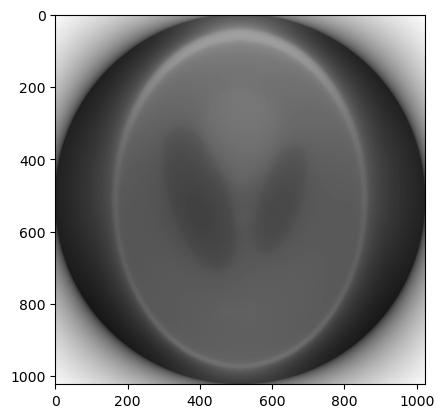

In [11]:
plt.imshow(w0.detach(), cmap='gray')

In [12]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    with torch.no_grad():
        gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
        if gcond:
            if y_last is not None:
                y_diff_norm = matrix_norm(y_last - y)
                y_norm = matrix_norm(y)
                return (y_diff_norm >= eta * y_norm)
            return True
        else:
            return False

In [13]:
def MLO_orthant(fh, y, lh, last_pts: list, l=0, kappa = 0.45, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph=True)
    grad_fhy0 = y.grad.clone()
    y.grad = None
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
    #if True:
        print(l, ' : coarse correction activated')
        last_pts[l] = y.detach()
    
        x0 = x.detach().requires_grad_(True)
        fH = lambda x: kl_distance_rev(x, b[l+1], A[l+1]) 
        #+ lbd * fcts.tv_huber(fcts.nabla(x),rho)
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad = None

        kappa = R(grad_fhy0) - grad_fHx0

        del grad_fHx0

        with torch.no_grad():
            psi = lambda x: fH(x) + torch.sum(kappa * x)
            lH = orthant_bounds_optimized(y, x, P_inf, lh, P_nonzero[l])
        
        for i in range(maxIter[l+1]):
            #x.retain_grad()
            val = fcts.mirror_descent_IS(psi, x, tau[l+1], lH)
            x = val.detach().requires_grad_(True)
            del val
            x.grad = None
            
        if l < max_levels-1:
            x, last_pts = MLO_orthant(psi, x, lH, last_pts, l+1)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval = fcts.mirror_descent_IS(fh, y, tau[l], lh)
        y = yval.detach().requires_grad_(True)
        del yval
        y.grad = None
    return y, last_pts


In [14]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

norm_fval = []
norm_fval.append(torch.tensor(1.))

fhz = fh(z0)

fhz.backward(retain_graph=True)
Gz0 = matrix_norm(z0.grad)
z0.grad = None

norm_grad = []
norm_grad.append(torch.tensor(1.))

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(3):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_orthant(fh, z0, lh, last_pts)
    iteration_end_time_ML = time.time()

    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML
    iteration_times_ML.append(iteration_time_ML)

    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    fval = fh(z0)
    norm_fval.append((fval/fhz).item())
    fval.backward(retain_graph=True)
    norm_grad.append((matrix_norm(z0.grad)/Gz0).item())
    z0.grad = None
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

print(f"Overall time for all iterations: {sum(iteration_times_ML):.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 0: 41441068.101568095 - Time: 26.586895 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 1: 40285196.47524178 - Time: 24.940992 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
Iteration 2: 39170938.20280523 - Time: 26.308498 seconds
Overall time for all iterations: 77.836385 seconds


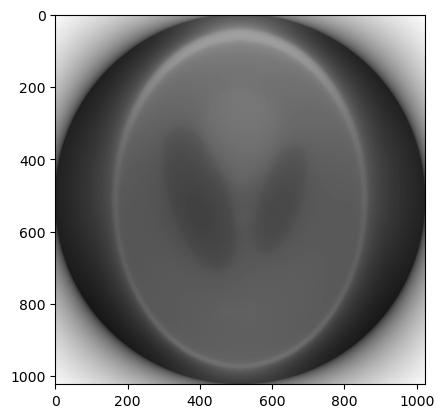

In [15]:
plt.imshow(w0.detach(), cmap='gray')

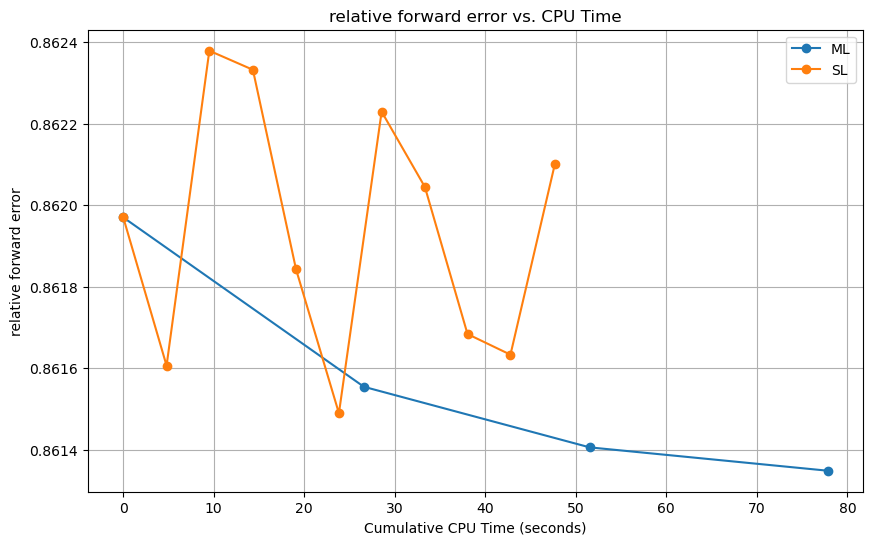

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, rel_f_err, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, rel_f_err_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('relative forward error')
plt.title('relative forward error vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

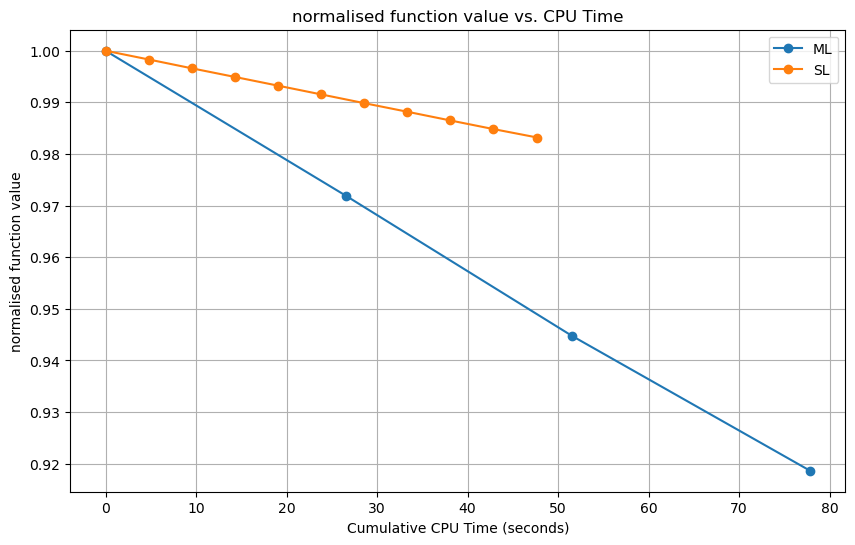

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, norm_fval, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, norm_fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('normalised function value')
plt.title('normalised function value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

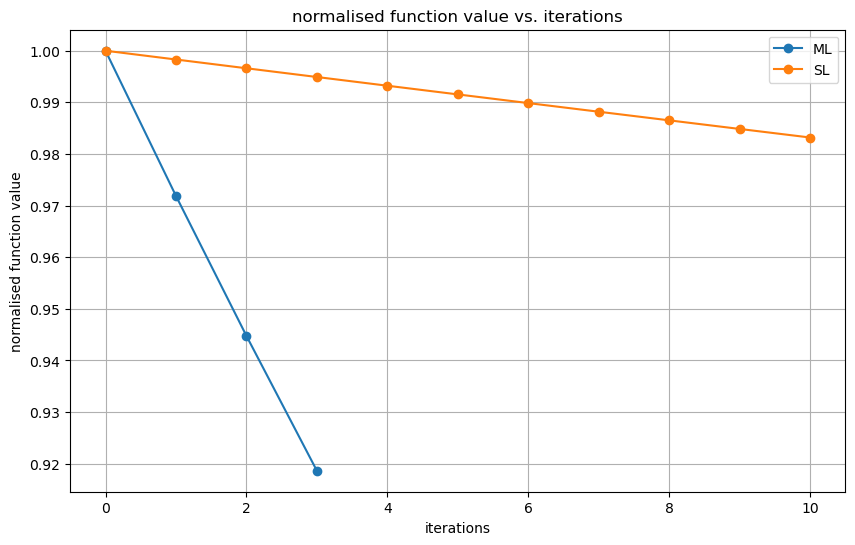

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_fval)), norm_fval, marker='o', linestyle='-', label = 'ML')
plt.plot(range(len(norm_fval_SL)), norm_fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('iterations')
plt.ylabel('normalised function value')
plt.title('normalised function value vs. iterations')
plt.grid(True)
plt.legend()
plt.show()